<a href="https://colab.research.google.com/github/MdSourovAhmed/AL/blob/main/TON_IOT_NETWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IDS Data Visualization and Confusion Matrices **

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report


#  === 1. Load Dataset ===

In [2]:
df = pd.read_csv("train_test_network.csv")

# **=== 2. Drop Unnecessary Columns ===**

In [3]:
drop_columns = [
    'src_ip', 'dst_ip', 'dns_query', 'ssl_subject', 'ssl_issuer',
    'http_uri', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types',
    'weird_addl', 'weird_notice', 'type'
]
df = df.drop(columns=drop_columns, errors='ignore')

# **=== 3. Encode Categorical Columns ===**

In [4]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# **Backup original with decoded labels for plots**

In [13]:
df_vis = df.copy()
for col, le in label_encoders.items():
    df_vis[col] = le.inverse_transform(df[col])

# **Plot class distribution**

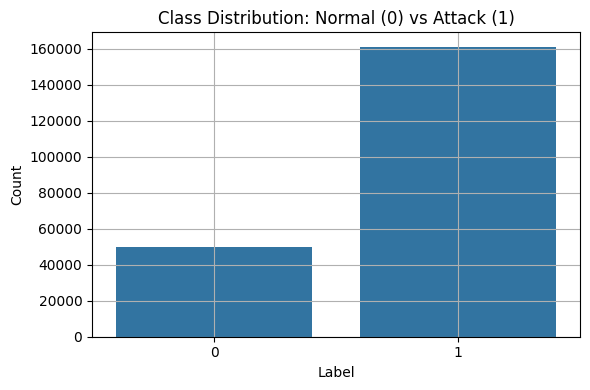

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_vis, x='label')
plt.title("Class Distribution: Normal (0) vs Attack (1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# **Correlation heatmap**

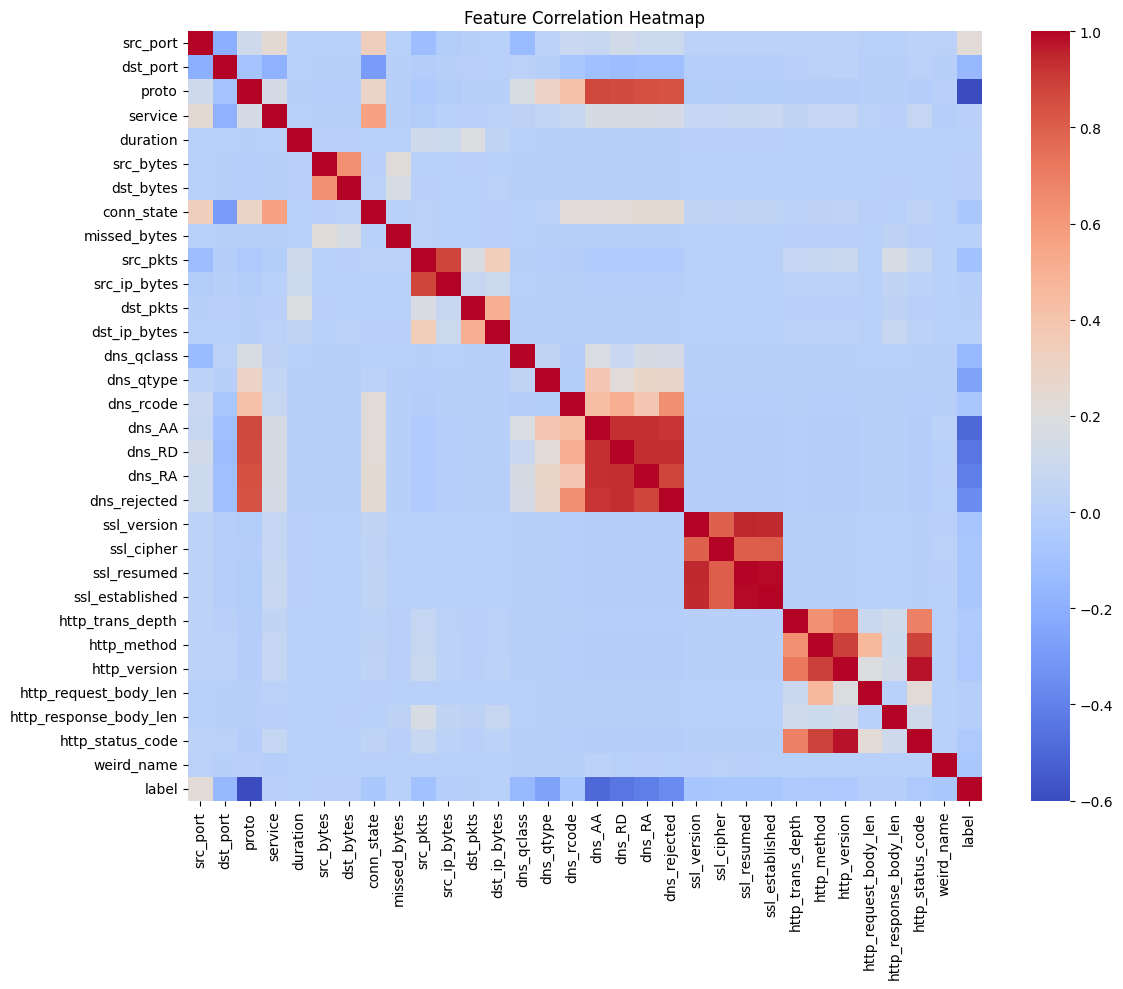

In [22]:
plt.figure(figsize=(12, 10))
correlation = df.corr()
sns.heatmap(correlation, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# **Boxplots of selected features**

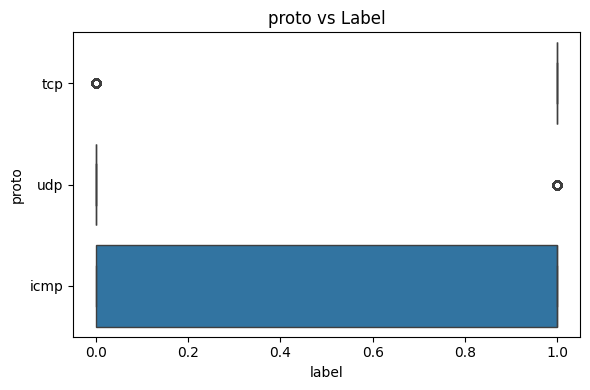

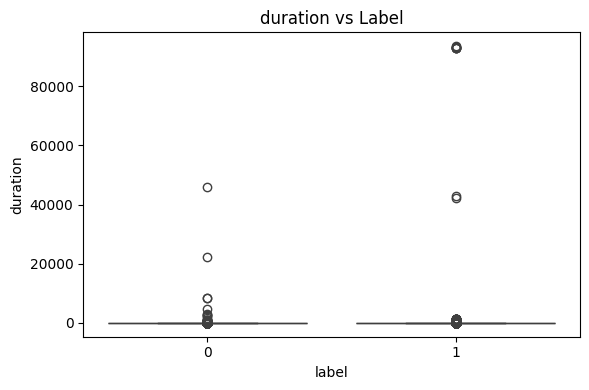

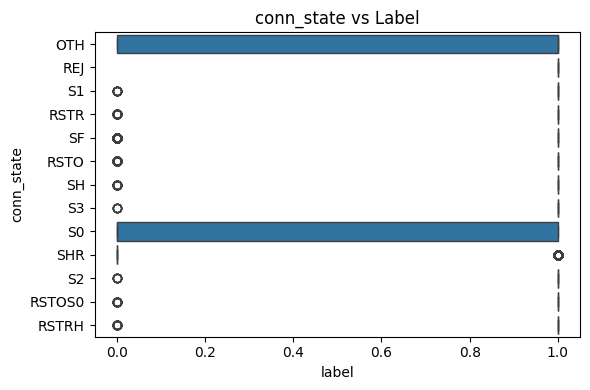

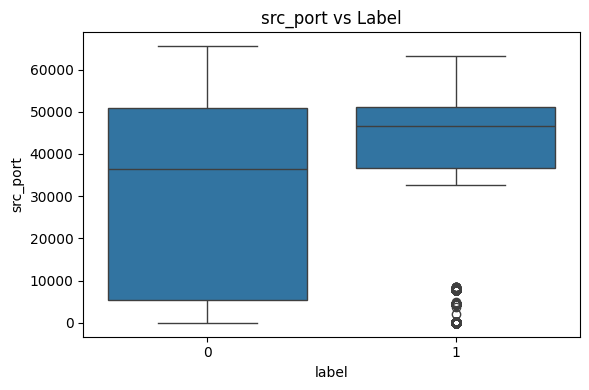

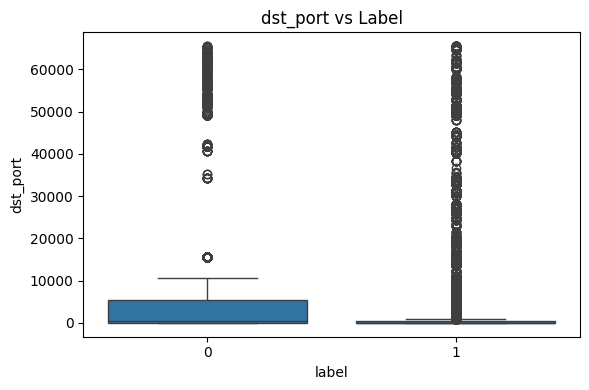

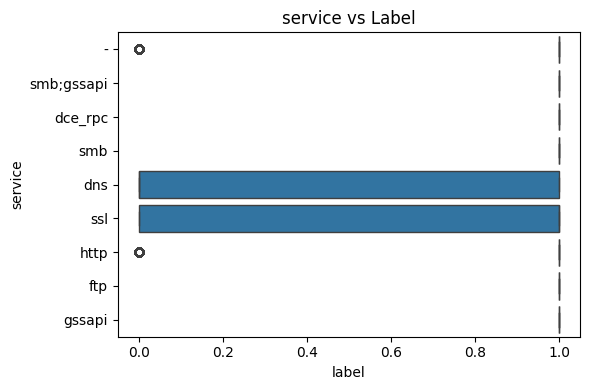

In [23]:
important_features = ['proto', 'duration', 'conn_state', 'src_port', 'dst_port', 'service']
for feature in important_features:
    if feature in df_vis.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='label', y=feature, data=df_vis)
        plt.title(f"{feature} vs Label")
        plt.tight_layout()
        plt.show()

# **=== 4. Prepare Features and Target ===**

In [5]:
X = df.drop(columns=['label'])
y = df['label']

# **=== 5. Scale Features ===**

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **=== 6. Sample for Lightweight Training ===**

In [7]:
df_sampled = df.sample(n=10000, random_state=42)
X_sample = df_sampled.drop(columns=['label'])
y_sample = df_sampled['label']
X_sample_scaled = scaler.fit_transform(X_sample)

# **=== 7. Train-Test Split ===**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_sample_scaled, y_sample, test_size=0.2, random_state=42)


## **=== 8. Define Lightweight Models ===**

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=10),
    "KNN": KNeighborsClassifier(n_neighbors=3)
}


# **=== 9. Train Models and Evaluate ===**

In [10]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    results[name] = {
        'model': model,
        'f1_score': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }


# **=== 10. Display Performance Summary ===**

In [11]:
print("\nModel Performance Summary:")
for name, res in results.items():
    print(f"{name}: F1 Score = {res['f1_score']:.4f}, AUC = {res['roc_auc']:.4f}")



Model Performance Summary:
Logistic Regression: F1 Score = 0.9695, AUC = 0.9807
Decision Tree: F1 Score = 0.9967, AUC = 0.9932
Random Forest: F1 Score = 0.9984, AUC = 0.9975
KNN: F1 Score = 0.9944, AUC = 0.9920


# **Confusion matrices plot**

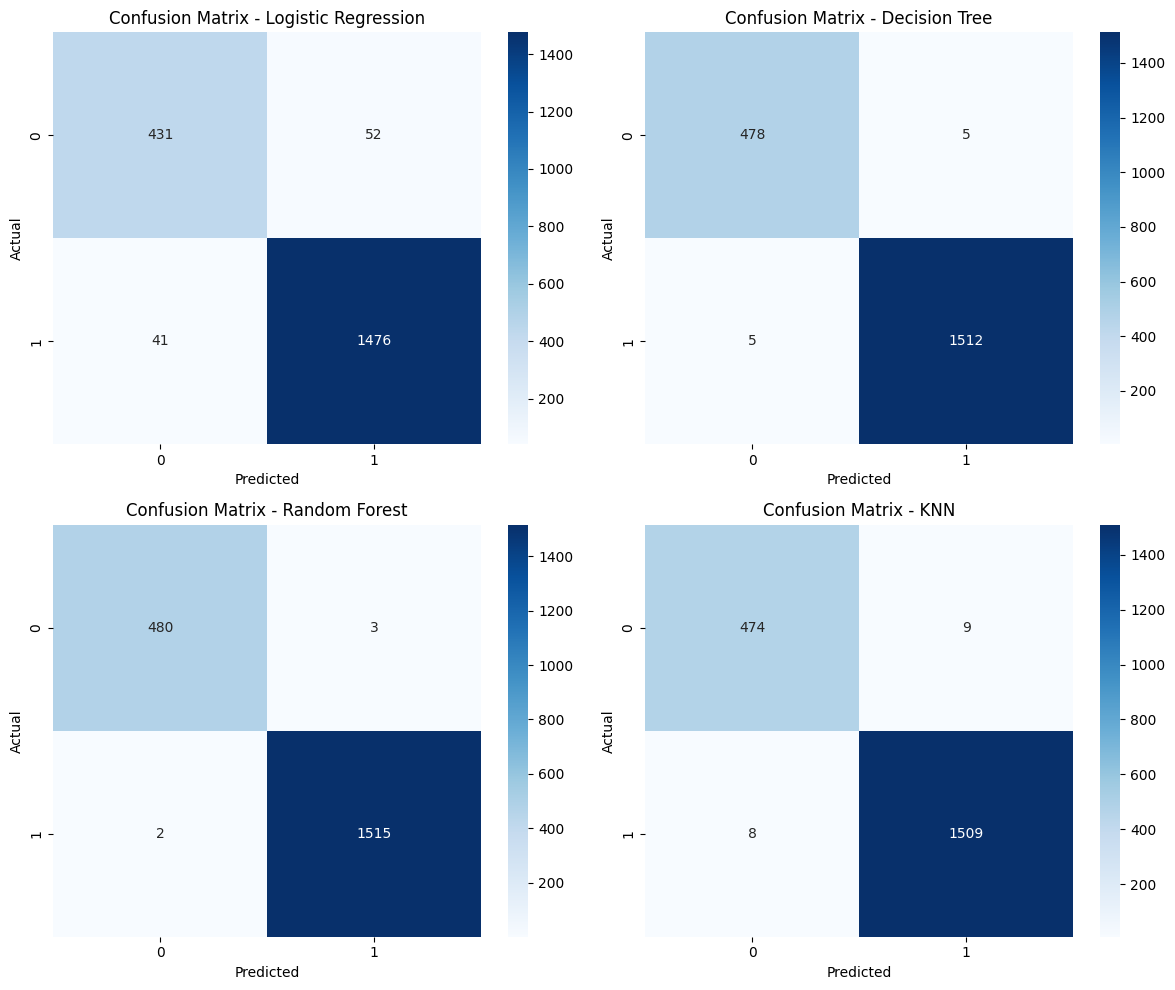

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res["confusion_matrix"], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# **=== 11. Plot ROC Curves ===**

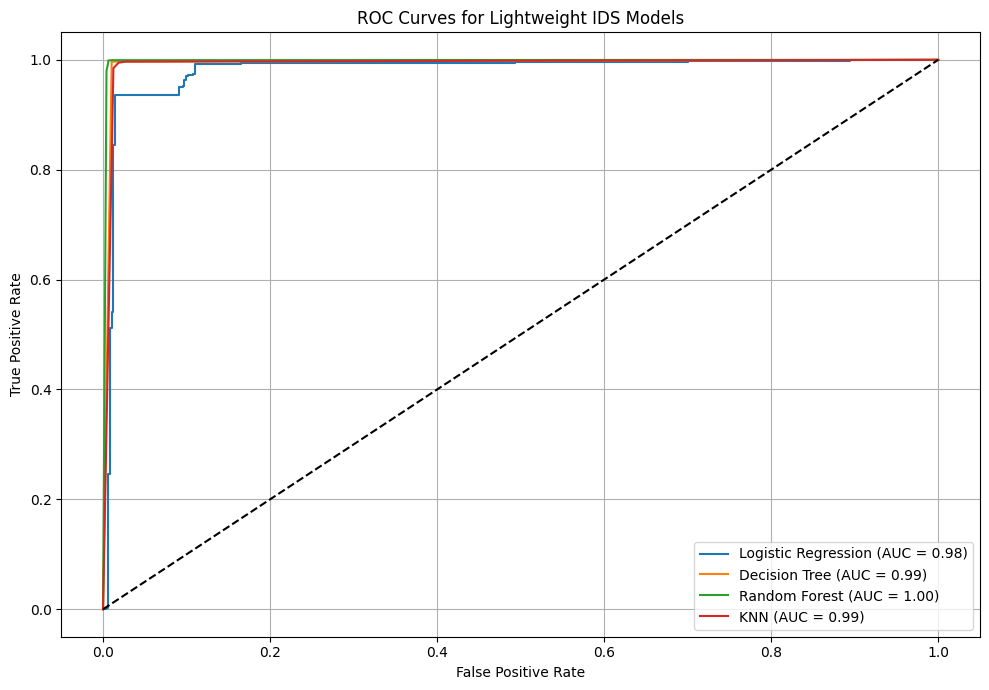

In [12]:
plt.figure(figsize=(10, 7))
for name, res in results.items():
    plt.plot(res['fpr'], res['tpr'], label=f"{name} (AUC = {res['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Lightweight IDS Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


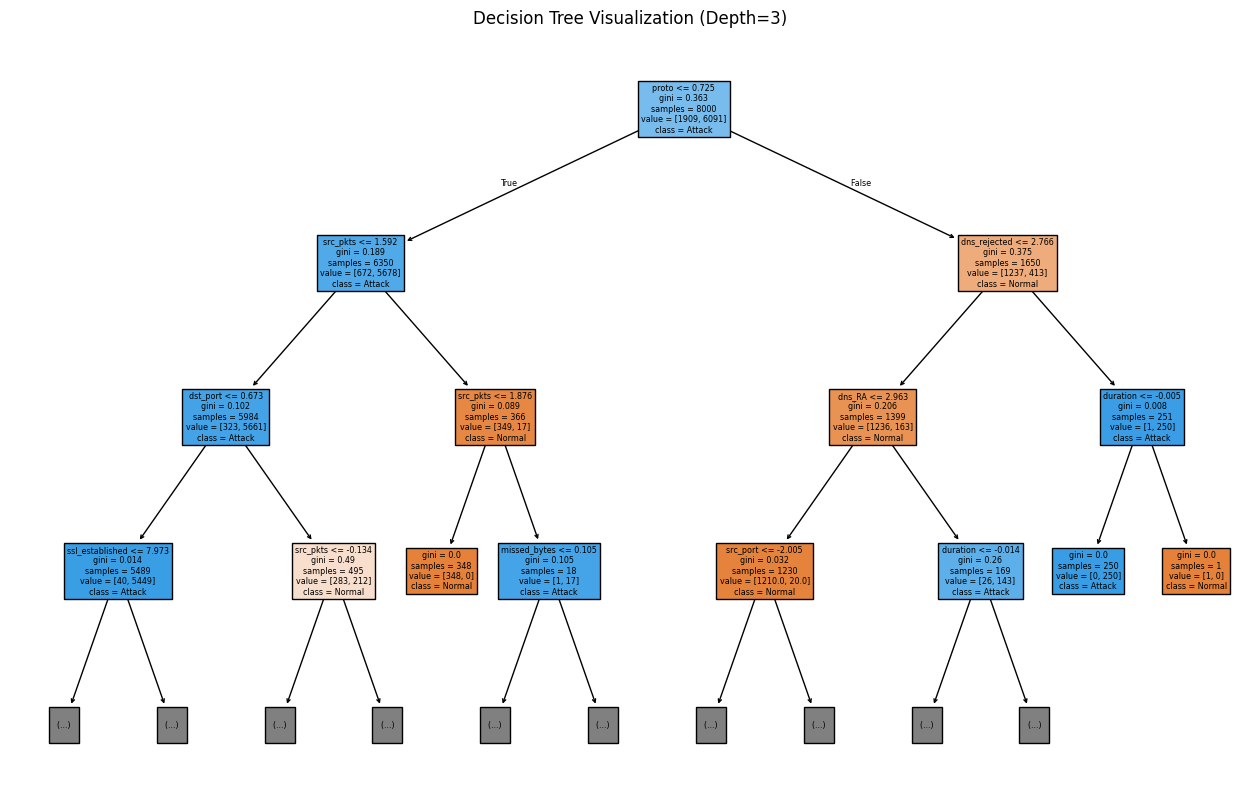

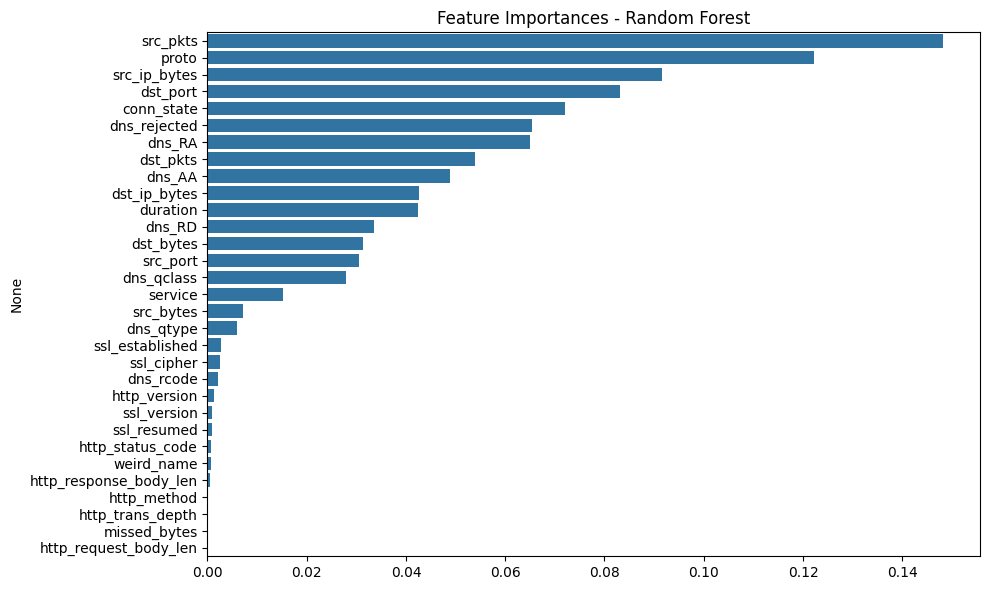

In [27]:
# Plot a decision tree if applicable
if "Decision Tree" in results:
    plt.figure(figsize=(16, 10))
    plot_tree(results["Decision Tree"]['model'], filled=True, max_depth=3, feature_names=X.columns, class_names=['Normal', 'Attack'])
    plt.title("Decision Tree Visualization (Depth=3)")
    plt.show()

# Plot a feature importance bar chart for Random Forest
if "Random Forest" in results:
    import numpy as np
    rf_model = results["Random Forest"]['model']
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=features[indices])
    plt.title("Feature Importances - Random Forest")
    plt.tight_layout()
    plt.show()